In [1]:
# # Warnings
import warnings
warnings.filterwarnings("ignore")


# # Manipulação de dados e arquivos
import math
import pandas as pd
import numpy as np
from scipy.ndimage import shift
import os
import sys
import tabula

np.random.seed(0)

# # Tempo
import time
from datetime import datetime


# # Gráficos
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm


# # Preprocessing
# Transformação dos dados
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer

# splitting
from sklearn.model_selection import TimeSeriesSplit


# # Modelos
# Random Walk
from pmdarima.arima import auto_arima

# ETS
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon

# SVR
from sklearn.svm import SVR

# NNs - Layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU

# NN - Optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# NN - Tuning
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# Bayesian Network
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator
import daft

# # Metricas de desempenho básicas
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import root_mean_squared_error as rmse


# Configurações
# pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Funções auxiliares

## Pré-processamento

In [2]:
# Obtenção das macrorregiões do Ceará 
def pdf_Preprocessing(path):
    raw_pdf = tabula.read_pdf(path, pages='all')

    list_raw_pdf = []

    for page in raw_pdf:
        # Tratamento dos dados
        page.drop(axis=0, index=[0], inplace=True)
        add = pd.Series(page['Unnamed: 1'], name=False)
        add.index=page['MUNICÍPIOS POR REGIÃO']
        add.rename_axis(index='', inplace=True)
        list_raw_pdf.append(add)

    df_pdf = pd.concat(list_raw_pdf)
    df_pdf = pd.DataFrame(df_pdf)
    df_pdf.columns = ['Regiao']
    
    return df_pdf


# Obtenção da quantidade de queimadas por município
def queimadas_Preprocessing(path, files_names):
    list_raw_queimadas = []  # drop: Satelite, Pais, Estado, Bioma, Precipitacao, Latitude, Longitude, FRP
    
    for file in files_names:
        df = pd.read_csv(filepath_or_buffer=os.path.join(path, file))
        df.drop(columns=['Satelite', 'Pais', 'Estado', 'Bioma', 'Precipitacao', 'Latitude', 'Longitude', 'FRP'])
        list_raw_queimadas.append(df)
        
    raw = pd.concat(list_raw_queimadas, ignore_index=True)
    raw.loc[:, 'DataHora'] = pd.to_datetime(raw['DataHora'], format='%Y/%m/%d %H:%M:%S')
    raw = raw.drop_duplicates()
    raw = raw.sort_values('DataHora', ignore_index=True)
    
    
    return raw

# Criando o agregado mensal por região
def regiao_mensal_Preprocessing(dataframe_regioes, dataframe_queimadas):
    # # Criando coluna com as regiões
    dataframe_queimadas.loc[:, 'Municipio'] = dataframe_queimadas['Municipio'].str.upper()  # Padronizando todas as strings em maiúsculas (upper)
    regioes = dataframe_regioes.loc[dataframe_queimadas['Municipio'], :].values.flatten()
    dataframe_queimadas['Regiao'] = regioes.copy()
    
    
    # # Realizando agregado mensal
    # Acrescentando a coluna de contagem de queimadas
    top_region = dataframe_queimadas.Regiao.value_counts().index
    dataframe_queimadas['Count'] = np.repeat(1, len(dataframe_queimadas))
    
    # Criando range com todas as datas
    datai = datetime(year=1998, month=7, day=1).date()  # Essa sempre será a data inicial, pois foi quando o INPE começou o registro. 
    dataf = dataframe_queimadas.loc[len(dataframe_queimadas)-1, 'DataHora'].date()
    dates = pd.date_range(datai, dataf, freq='MS')
        
    mensal_list = []
    for regiao in top_region:
        # Realizando agregado mensal
        temp2 = dataframe_queimadas[dataframe_queimadas['Regiao'] == regiao]
        temp2.loc[:, 'DataHora'] = pd.PeriodIndex(temp2['DataHora'], freq="M")
        temp2 = temp2.groupby('DataHora')['Count'].sum()
        temp2 = pd.DataFrame(data={'Data': temp2.index, 
                                   'Count': temp2.values})
        
        # Modificando tipo de dados e adicionando datas faltosas
        temp2['Data'] = temp2['Data'].astype('datetime64[ns]')
        
        to_add = pd.DataFrame(data={'Data': dates, 
                                    'Count': np.tile(0, len(dates))})
        
        full = pd.concat([temp2, to_add])
        full = full.drop_duplicates(subset='Data')
        full.sort_values(inplace=True, by='Data',ignore_index=True)
        full['Regiao'] = np.tile(regiao, len(full))
        
        
        mensal_list.append(full.copy())
    
    mensal = pd.concat(mensal_list, ignore_index=True)
    return mensal


def Dataframe_Sig_Lags(y, nLags = 5, alpha=0.05, plot=True):
    # Calculando a autocorrelação
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    
    # Obtendo os valores de lags
    significantLags = []
    for c in range(1, len(pac)):
        # print(pac[c], pac_ci[c][0], pac_ci[c][1])
        if pac[c] < pac_ci[c][0] - pac[c] or pac[c] > pac_ci[c][1] - pac[c]:
            significantLags.append(c)
    
    # Plotando
    if plot == True:
        pd.DataFrame(pac)[1:].plot(kind='bar', figsize=(8, 3), legend='pacf',
                                xlabel='lag', ylabel='pacf_'+y.name);
        print('\n\nOs lags significantes são: :', significantLags)
    
    return significantLags


# Obtenção de lags significantes
def get_significant_lags(df, nLags=40, alpha=0.01):
    sig_lags_dict = {}
    sig_lags_len = []
    
    for col in df.columns:
        sig_lags = Dataframe_Sig_Lags(df[col], nLags=nLags, alpha=alpha, plot=False)
        sig_lags_len.append(len(sig_lags))
        sig_lags_dict[col] = sig_lags
    
    cols = [f'lag_#{c}' for c in range(1, (np.max(sig_lags_len))+1)]
    
    return pd.DataFrame(sig_lags_dict.values(), index=sig_lags_dict.keys(), columns=cols)


def bayesian_data_processing(df, lags_df):
    dict_diff = {}
    # forecasting_dict = {}
    if type(df) == type(dict()):
        for c, col in enumerate(df.keys()):
            dataframe = pd.DataFrame(df[col], index=df[col].index, columns=[col])
            lag_vals = lags_df.query(f'index == "{col}"').dropna(axis=1).values.flatten()

            for lag in lag_vals:
                dataframe[f'{col}_lag_{int(lag)}'] = dataframe[col].shift(int(lag))
            
            dataframe = dataframe.dropna()
            dict_diff[col] = dataframe
    else:
        for c, col in enumerate(df.columns):
            dataframe = pd.DataFrame(df[col], index=df.index, columns=[col])
            lag_vals = lags_df.query(f'index == "{col}"').dropna(axis=1).values.flatten()

            for lag in lag_vals:
                dataframe[f'{col}_lag_{int(lag)}'] = dataframe[col].shift(int(lag))
            
            dataframe = dataframe.dropna()
            dict_diff[col] = dataframe
            
    return dict_diff


# Criação da lista de querys para a rede bayesiana
def query_tuple_model(df):
    target = df.columns[0]
    list_tuples = [(col, target) for col in df.columns if col != target]
    
    return list_tuples


# Criação do array com as médias de cada bin
def bin_means(discretizer, var_index=0):
    bin_edges = discretizer.bin_edges_[var_index]
    bin_means = np.array([(bin_edges[c] + bin_edges[c+1]) / 2 for c in range(len(bin_edges)-1)])
    
    return bin_means


# Split de treino e teste
def split_data(data, test_proportion):
    test_size = math.ceil(len(data) * test_proportion)
    train_size = len(data) - test_size

    train = data[:train_size]
    test = data[train_size:train_size + test_size]
    return train, test


def logit_transform(dataframe, inverse=False):
    index = dataframe.index
    columns = dataframe.columns
    dataframe = dataframe.values
    if inverse is False:
        return pd.DataFrame(1 / (1 + np.exp(-dataframe)), index=index, columns=columns)
    else:
        return pd.DataFrame(np.log(dataframe / (1 - dataframe)), index=index, columns=columns)
    
    


## Modelagem

In [3]:
def u_theil(y_true, y_pred):
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum(y_true[1:] - shift(y_true, 1)[1:])**2
    
    return numerator/denominator

# Cálculo das métricas para redes bayesianas
def calculate_metrics_individual_models_bn(real, preds, col):
    return pd.DataFrame({'MAE': mae(real, preds),
                         'MAPE': mape(np.array(real) + 1, np.array(preds) + 1),
                         'U_theil': u_theil(real, preds)}, index=[col])
                        #  'RMSE': rmse(real, preds)}, index=[col])
                         
 

## Plotagem

In [4]:
def plot_regions(dataframe, date_column, count_column, region_column):
    # Calculando a data correspondente a 80% do tamanho da série
    if date_column not in dataframe.columns:
        total_dates = dataframe.index.values
        cutoff_index = int(len(total_dates) * 0.8)
        cutoff_date = total_dates[cutoff_index]
    else:
        total_dates = dataframe[date_column].sort_values().unique()
        cutoff_index = int(len(total_dates) * 0.8)
        cutoff_date = total_dates[cutoff_index]

    # Obtendo as regiões únicas
    unique_regions = dataframe.columns
    num_regions = len(unique_regions)

    # Criando o subplot com 2 colunas
    rows = (num_regions + 1) // 2
    fig = make_subplots(rows=rows, cols=2, subplot_titles=unique_regions)

    # Adicionando os gráficos para cada região
    for c, region in enumerate(unique_regions):
        region_data = dataframe.iloc[:, c]
        row = (c // 2) + 1
        col = (c % 2) + 1

        # Adicionando a linha do gráfico
        fig.add_trace(
            go.Scatter(x=total_dates, y=region_data, mode='lines', name=region),
            row=row, col=col
        )

        # Adicionando a linha vertical
        fig.add_trace(
            go.Scatter(x=[cutoff_date, cutoff_date], y=[0, region_data.max()],
                       mode='lines', line=dict(dash='dash', color='red'), name='80% da série'),
            row=row, col=col
        )

    # Atualizando o layout
    fig.update_layout(height=rows * 300, width=900, title_text="Queimadas por Região", showlegend=False)
    fig.update_xaxes(title_text="Data")
    fig.update_yaxes(title_text="Nº Queimadas")

    # Exibindo o gráfico
    fig.show()


def plotar_bn(dataframe, bn_preds):
    starting_date = dataframe.index[0]
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 15))
    axes = axes.flatten()
    date_df = pd.DataFrame(index=bn_preds.columns)
    for c, col in enumerate(dataframe.columns):
        plot_bn = bn_preds[f'{col}_preds'].dropna()
        
        dataframe_index = pd.date_range(start=starting_date, periods=len(dataframe), freq='MS')
        bn_index = len(dataframe) - len(plot_bn)
        bn_index = dataframe_index[bn_index:]
        inicio_teste = bn_index[int(len(bn_index)*.8)]

        axes[c].plot(dataframe_index, dataframe[col].values, label=f'{col}_data')
        axes[c].plot(bn_index, plot_bn.values, label=f'{col}_BN')
        axes[c].axvline(x=inicio_teste, color='red', linestyle='--', label='Início Teste')
        axes[c].set_title(f'{col}')
        # axes[c].legend()
        date_df.loc[col, 'Data_teste'], date_df.loc[col, 'idx'] = inicio_teste.date(), int(len(bn_index)*.8)
        
    plt.tight_layout()
    plt.show()
    return date_df

# Pré-processamento

In [5]:
# Pré-processamento PDF
PATH_pdf = r'C:\Users\Gabriel Lucena\OneDrive\Documentos Importantes\Mestrado\Disciplinas\Mét. Quant\Artigo\Data\2022_APRECE_Lista de regiões.pdf'
pdf = pdf_Preprocessing(path=PATH_pdf)


# Pré-processamento queimadas
PATH_queim = r'C:\Users\Gabriel Lucena\OneDrive\Documentos Importantes\Mestrado\Disciplinas\Mét. Quant\Artigo\Data\Queimadas'
files_name = os.listdir(PATH_queim)
inpe = queimadas_Preprocessing(path=PATH_queim, files_names=files_name)


# Criando agregado mensal empilhado de cada regiao
agg_stack = regiao_mensal_Preprocessing(dataframe_regioes=pdf, dataframe_queimadas=inpe)


# Criando agregado para cada região
agg_region = pd.DataFrame(agg_stack.pivot(index='Data', columns='Regiao', values='Count').to_numpy(), 
                          index=agg_stack['Data'].unique(), columns=agg_stack['Regiao'].unique())

# Usar o conjunto para a região do Cariri
data_2use = pd.DataFrame(agg_region['CARIRI'], 
                         index=agg_region.index, columns=['CARIRI'])
display(data_2use)


# proporção do teste
test_proportion = 0.2
test_index = int(len(agg_region)*(1-test_proportion))

,CARIRI
1998-07-01,3
1998-08-01,5
1998-09-01,136
1998-10-01,401
1998-11-01,164
...,...
2024-11-01,3660
2024-12-01,2893
2025-01-01,544
2025-02-01,348


# Descritiva

In [6]:
plot_regions(dataframe=data_2use, date_column='Data', count_column='Count', region_column='Regiao')

In [7]:
# Veirifcação dos lags a 1% de significância
train, test = data_2use.iloc[:test_index], data_2use.iloc[test_index:]
lags_data = get_significant_lags(train, nLags=40, alpha=0.01)
lags_data

,lag_#1,lag_#2,lag_#3,lag_#4
CARIRI,1,2,11,12


# Modelagem Bayesiana (Caso Cariri)                                                        

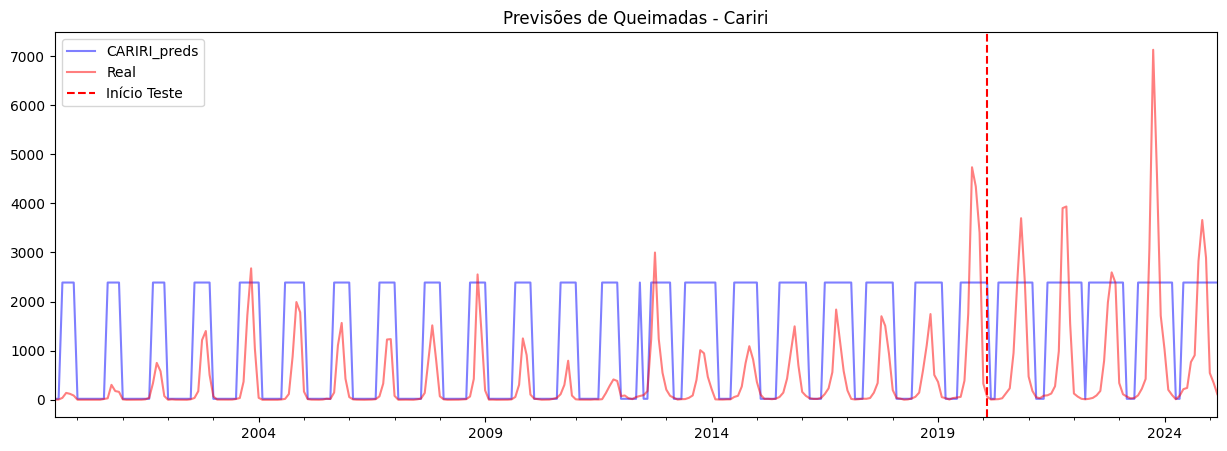

In [8]:
def modelling_by_BN(df, lags_df=lags_data, bins=2, test_proportion=test_proportion, diff=False):
    if diff == True:
        df = df.diff().dropna()
        
    dict_bn = bayesian_data_processing(df, lags_df=lags_df)
    dict_preds, dict_results = {}, {}
    
    # Criando um modelo para cada região
    for c, col in enumerate(dict_bn.keys()):
        # Split
        train_df, test_df = split_data(dict_bn[col], test_proportion=test_proportion)
        
        # Discretização
        desc = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')  # Metodologia de igual frequência.
        desc.fit(train_df.values)
        medias_bins = dict(enumerate(bin_means(desc)))
        
        train_df_desc = pd.DataFrame(desc.transform(train_df.values), 
                                     index=train_df.index, 
                                     columns=[f'{column}_discretized' for column in train_df.columns]).astype('int')
        
        test_df_desc = pd.DataFrame(desc.transform(test_df.values), 
                                    index=test_df.index, 
                                    columns=[f'{column}_discretized' for column in test_df.columns]).astype('int')
        
            
        # Criando o modelo
        target = train_df_desc.columns[0]
        tuple_list = query_tuple_model(train_df_desc)
        
        bn_model = BayesianNetwork(tuple_list)       
        bn_model.fit(train_df_desc, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)
        
        infer = VariableElimination(bn_model)
        
        
        # Inferência treino
        train_inputs = train_df_desc.drop(columns=[target]).to_dict(orient='records')
        train_forecasts = []
        
        for trn in range(len(train_df_desc)):
            forecast_interval = np.argmax(infer.query([target], evidence=train_inputs[trn]).values)
            train_forecasts.append(medias_bins[forecast_interval])
        

        # Inferência teste
        test_inputs = test_df_desc.drop(columns=[target]).to_dict(orient='records')
        test_forecasts = []

        for tst in range(len(test_df_desc)):
            forecast_interval = np.argmax(infer.query([target], evidence=test_inputs[tst]).values)
            test_forecasts.append(medias_bins[forecast_interval])

            
            # Update do modelo
            bn_model.fit_update(pd.DataFrame(test_df_desc.iloc[0, :].values.reshape(1, -1), index=[0], columns=test_df_desc.columns))
            

        # Juntando as previsões dos conjuntos
        total_preds = pd.DataFrame(np.concatenate([train_forecasts, test_forecasts]), 
                          index=pd.date_range(start=train_df.index[0], end=test_df.index[-1], freq='MS'), 
                          columns=[f'{col}_preds'])
        
        if diff == True:
            # Ajustando as previsões
            last_lag = int(lags_df.loc[col, :].dropna().max())
            total_preds = total_preds.values.reshape(-1, ) + df.iloc[last_lag:, c]
            total_preds = total_preds.clip(lower=0)
            total_preds = pd.Series(total_preds.values.astype(int), index=total_preds.index)
            total_preds = total_preds.astype(int)
            total_preds[total_preds < 0] = np.nan
            
            dict_preds[f'{col}_preds'] = pd.Series(total_preds.values.reshape(-1, ), index=total_preds.index)
        else:
            dict_preds[f'{col}_preds'] = pd.Series(total_preds.values.reshape(-1, ), index=total_preds.index)

        # Calculando as métricas
        results = calculate_metrics_individual_models_bn(test_df[col], test_forecasts, col=col)
        dict_results[col] = pd.Series(results.values.flatten(), index=results.columns)
        dict_results[col].name = col
    
    # Convertendo em dataframe
    df_preds = pd.concat(list(dict_preds.values()), axis=1)
    df_preds.columns = dict_preds.keys()

    df_results = pd.concat(list(dict_results.values()), axis=1).T
    return df_preds, df_results

preds_2, results = modelling_by_BN(df=data_2use, lags_df=lags_data, bins=2, test_proportion=test_proportion, diff=False)

# Plotando os resultados
preds_2['Real'] = data_2use['CARIRI']
preds_2.plot(title='Previsões de Queimadas - Cariri', figsize=(15, 5), color=['blue', 'red'], alpha=0.5)
plt.axvline(x=preds_2.index[int(len(preds_2)*.8)], color='red', linestyle='--', label='Início Teste')
plt.legend()
plt.show()

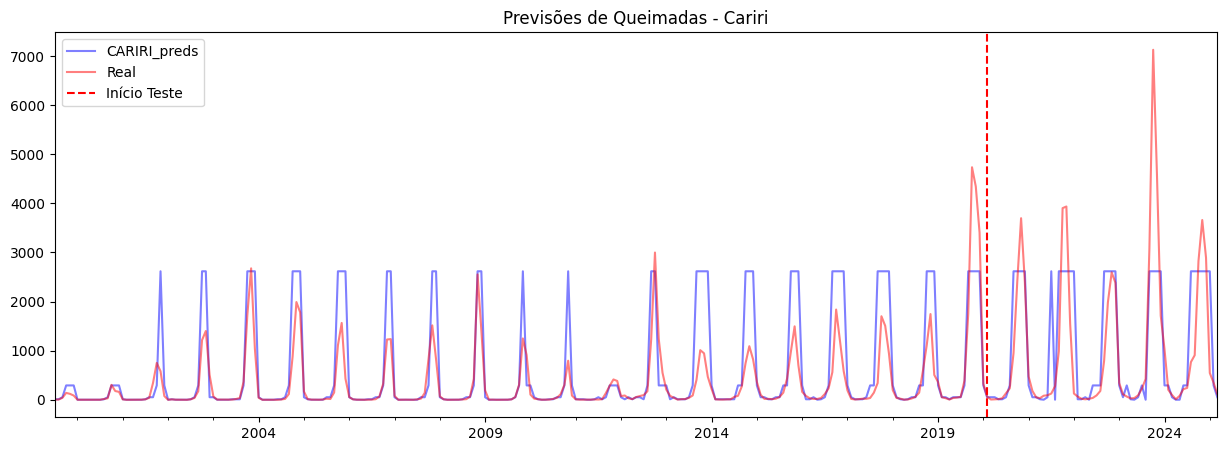

In [9]:
preds_5, results = modelling_by_BN(df=data_2use, lags_df=lags_data, bins=5, test_proportion=test_proportion, diff=False)

# Plotando os resultados
preds_5['Real'] = data_2use['CARIRI']
preds_5.plot(title='Previsões de Queimadas - Cariri', figsize=(15, 5), color=['blue', 'red'], alpha=0.5)
plt.axvline(x=preds_5.index[int(len(preds_5)*.8)], color='red', linestyle='--', label='Início Teste')
plt.legend()
plt.show()

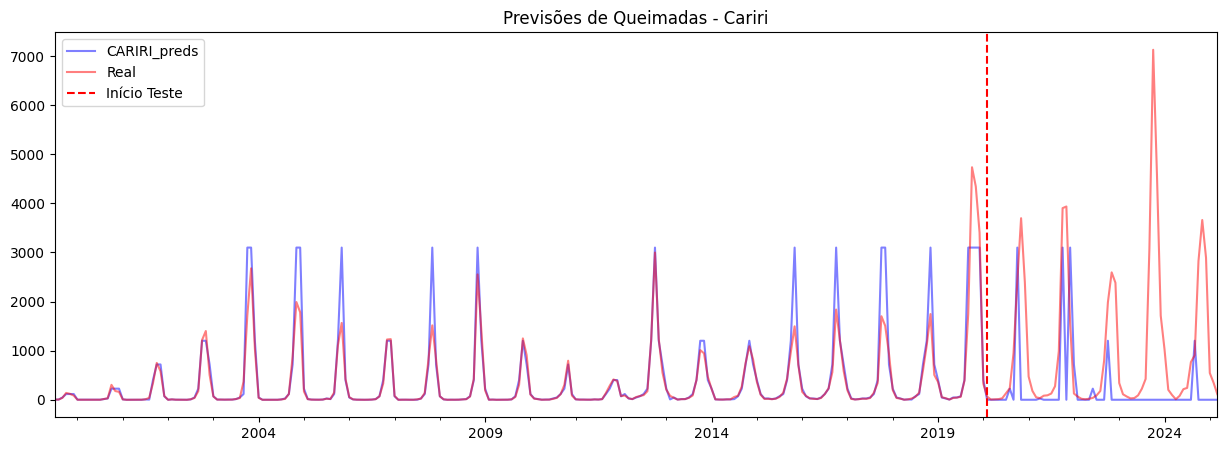

In [10]:
preds_25, results = modelling_by_BN(df=data_2use, lags_df=lags_data, bins=15, test_proportion=test_proportion, diff=False)

# Plotando os resultados
preds_25['Real'] = data_2use['CARIRI']
preds_25.plot(title='Previsões de Queimadas - Cariri', figsize=(15, 5), color=['blue', 'red'], alpha=0.5)
plt.axvline(x=preds_25.index[int(len(preds_25)*.8)], color='red', linestyle='--', label='Início Teste')
plt.legend()
plt.show()